# CCMP Version 2 Global Characteristic of SWH and WSP Seasonal cycle Least Square Fit Model with a 5 Parameter Fit

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [8]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import glob 
import datetime
#plotting libraries 
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib

#my functions
from running_mean import running_mean 
from shift_grid import shift_grid 
from unweighted_least_square_fit import least_square_fit 
from char_LSF_curve import character_LSF
from monthly_mean import monthly_average
import cartopy_fig_module as cart

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [4]:
nt, nlon, nlat = 8400, 1440, 529
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [5]:
filenames = sorted(glob.glob('/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_*_high_res.nc'))

#set nc variable in order to read attributes and obtained data: 
nc = Dataset(filenames[0], 'r')

#print key variables:
print(nc.variables.keys())

#longitude
for at in nc.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc.variables['lon'].getncattr(at)))

#laitude
for at in nc.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc.variables['lat'].getncattr(at)))
    
#time 
for at in nc.variables['time'].ncattrs():
    print("%s : %s" %(at, nc.variables['time'].getncattr(at)))
    

odict_keys(['time', 'lon', 'lat', 'wsp'])
units : degrees east
units : degrees north
units : days since 1900-01-01 00:00:00
calendar : julian


Call each data set and append the data from one year onto the end of the previous year 

In [6]:
#initialize 3D array and counters/counter array
wsp_array = np.ma.masked_all([nt, nlat, nlon])
time_array = []
i = 0
yc = 0
year_c = np.array([365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365])

#restrict filename from 1993 to 2015: 
filenames = filenames[0:23]

#loop through each filename to call data: 
for f in filenames: 
    
    #set nc variable in order to read attributes and obtained data: 
    nc_wnd = Dataset(f, 'r')
    #call wind speed data
    wsp = nc_wnd.variables['wsp'][:]
    time_i = num2date(nc_wnd.variables['time'][:], nc_wnd.variables['time'].units)
    #place the wsp and time data into the 3D arrays
    wsp_array[i:i+year_c[yc],:,:] = wsp
    time_array.append([time_i])
    #year counters: 
    i +=year_c[yc]
    yc += 1
    print(f)
    

/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1993_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1994_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1995_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1996_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1997_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1998_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1999_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/d

In [26]:
print(wsp_array.shape)

(8400, 529, 1440)


Initialize CCMP2 latitude and longitude 

In [9]:
#call lon and lat: 
lon = nc_wnd.variables['lon'][:]
lat = nc_wnd.variables['lat'][:]
#deresolve lon and lat:
lat_c = running_mean(data = lat, k_dim = [4,1], task = 'deresolve', fill_val = 'none')
lon_c = running_mean(data = lon, k_dim = [4,1], task = 'deresolve', fill_val = 'none')
#fix latitude vector: 
lat_c[132] = 66.25


Check to see if the WSP array includes data at 0 and 360 degrees 

Plot two plot to check data

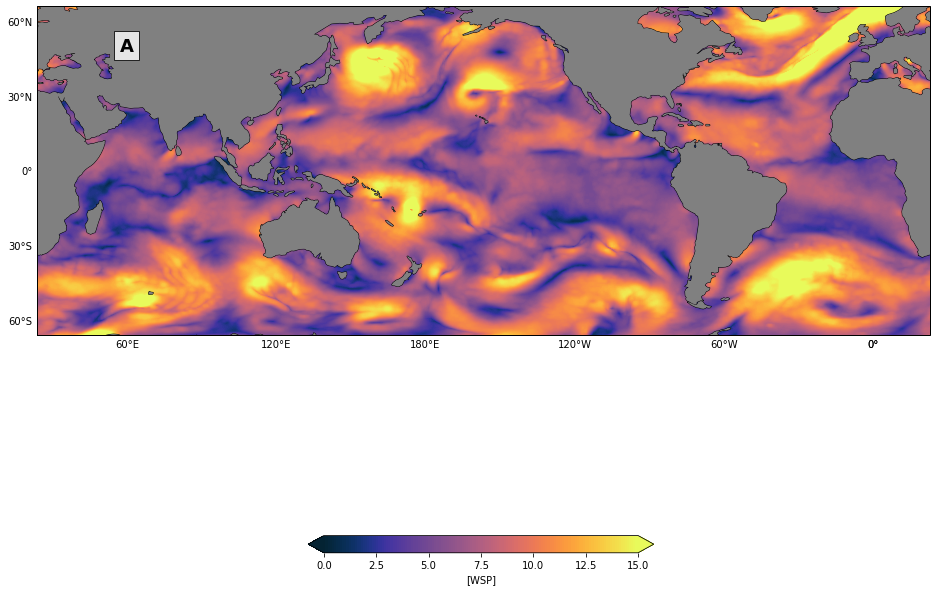

In [17]:
projection = ccrs.PlateCarree(central_longitude=-157.0)

resolution = '110m'

fig, axes = plt.subplots(1,1, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1 = axes

############## Subplot 1  ################# 
cart.set_subplots(ax1, projection, resolution, lon_min=-179, lon_max=180, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 15.1, 0.1)
cs1 = ax1.contourf(lon, lat, wsp_array[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color = 'black')
cax1 = plt.axes([.36, .06, 0.3, 0.02])
cart.set_cbar(cs1, cax1, fig, orientation='horizontal', cbar_label ='[WSP]', nbins = 7, fontsize = 10, 
              cbar_ticks=[], task='regular')
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)


Check to see if swh and wsp are masked arrays

In [18]:
print(np.ma.is_masked(wsp_array),np.ma.is_masked(wsp_array[8390,:,:])) #np.ma.is_masked(x) determines whether input has masked values

False False


Change the time list from lists of numpy masked arrays to a 1D array 

In [19]:
time_c = np.hstack(time_array)[0]

Deresolve each of the wsp 3D array such that the resolution of the figure matches that of Ifremer data

In [45]:
#reset nlon and nlat to i degree resolution: 
nlon_c = 360
nlat_c = 133

#initialize 3D array: 
wsp_array_dr = np.ma.masked_all([nt,nlat_c, nlon_c])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    wsp_array_d  = wsp_array[itime,:,:]
    #preform the deresolution via convolution 
    wsp_dr = running_mean(data = wsp_array_d, k_dim = [4, 4], task = 'deresolve', fill_val = 'none')
    #Save running mean wsp into 3D array: 
    wsp_array_dr[itime,:,:] = wsp_dr
    
print(wsp_array_dr.shape, np.ma.is_masked(wsp_array_dr))

(8400, 133, 360) False


In [41]:
print(wsp_array_dr[0,:,-1])
print('')
print(wsp_array_dr[0,:,0]) 
print('')
print(wsp_array_dr.shape)
print(lon_c)
print(lon_c.shape)
lon_cor = np.arange(0, 360, 1)
print(lon_cor)

[6.507839918136597 7.1403045654296875 7.341456800699234 8.280843406915665
 9.64922958612442 10.49868619441986 10.23246943950653 8.303071647882462
 4.802907034754753 3.6160214096307755 3.9888409078121185 5.21831801533699
 6.522847592830658 8.058024883270264 9.560929894447327 9.768724977970123
 9.651844263076782 9.993245601654053 9.904761552810669 9.881823658943176
 10.415277063846588 10.759100317955017 11.036854982376099
 11.133975088596344 10.977875411510468 10.498744428157806
 10.013256013393402 9.836551547050476 9.532617330551147 9.167530298233032
 8.419832587242126 7.854800820350647 8.604232430458069 8.801882088184357
 7.966036140918732 6.650640457868576 5.438102900981903 4.11873023211956
 2.9573847204446793 2.9921695441007614 3.5280349254608154
 3.9183859527111053 4.0511583387851715 4.173261374235153
 4.6088564693927765 5.107272058725357 5.683188945055008 6.149894297122955
 6.589156061410904 7.105353146791458 7.4508823454380035 7.5906490087509155
 7.6809841096401215 7.6222400963306

Check to see if the WSP array includes data at 0 and 360 degrees 

Plot two plot to check data

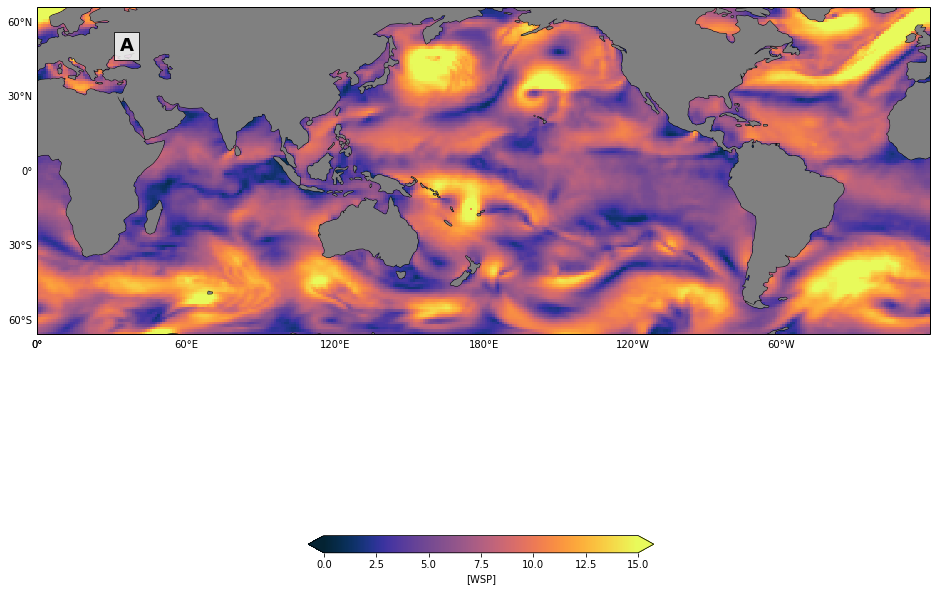

In [46]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '110m'

fig, axes = plt.subplots(1,1, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1 = axes

############## Subplot 1  #################
#Indian Ocean 
cart.set_subplots(ax1, projection, resolution, lon_min=-179, lon_max=180, lat_min=-66, lat_max=66)
cs1 = ax1.pcolor(lon_c, lat_c, wsp_array_dr[0,:,:], vmin=0, vmax=15, cmap=cmo.thermal, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color = 'black')
cax1 = plt.axes([.36, .06, 0.3, 0.02])
cart.set_cbar(cs1, cax1, fig, orientation='horizontal', cbar_label ='[WSP]', nbins = 7, fontsize = 10, 
              cbar_ticks=[], task='regular')
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)



Calculate the monthly averaged swh and wsp from 1993 to 2016

In [22]:
wsp_month_data = monthly_average(date_time = time_c, data = wsp_array_dr, fill_val = 'mask')

Save mean, meadian, standard deviation, and number of observations (will be later used to calculate the standard deviation of the mean) in separate np.array variables. Change each dictionary key from a list to a np.array:

In [23]:
#For wsp:
wsp_monthly_mean = np.ma.array(wsp_month_data['mean'])
wsp_monthly_median = np.ma.array(wsp_month_data['median'])
wsp_monthly_std = np.ma.array(wsp_month_data['std'])
wsp_monthly_n = np.ma.array(wsp_month_data['N'])

Check to see if the WSP array includes data at 0 and 360 degrees 

Plot two plot to check data

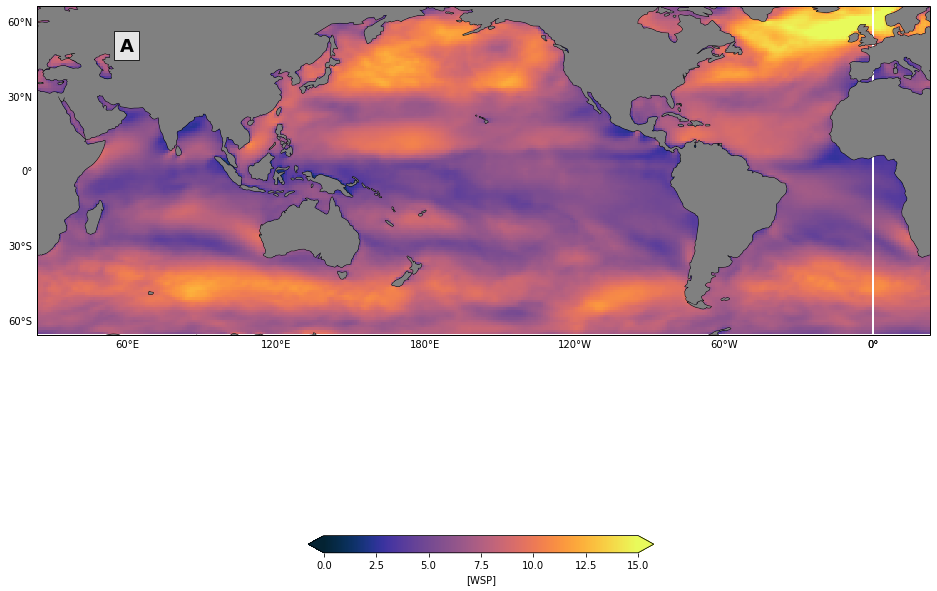

In [24]:
projection = ccrs.PlateCarree(central_longitude=-157.0)
resolution = '110m'

fig, axes = plt.subplots(1,1, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1 = axes

############## Subplot 1  #################
#Indian Ocean 
cart.set_subplots(ax1, projection, resolution, lon_min=-179, lon_max=180, lat_min=-66, lat_max=66)
cs1 = ax1.pcolor(lon_c, lat_c, wsp_monthly_mean[0,:,:], vmin=0, vmax=15, cmap=cmo.thermal, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color = 'black')
cax1 = plt.axes([.36, .06, 0.3, 0.02])
cart.set_cbar(cs1, cax1, fig, orientation='horizontal', cbar_label ='[WSP]', nbins = 7, fontsize = 10, 
              cbar_ticks=[], task='regular')
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)



Create a loop to go through each grid point and compute the unweighted least square fit and the characteristics of the fit (e.g. residual, amplitude, phase constant, and coefficient of determination) 

In [25]:
#initialize masked arrays to save data in:
wsp_hfit_m = np.ma.masked_all([wsp_monthly_mean.shape[0], nlat, nlon])
wsp_rms_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_amp1_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_phase1_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_amp2_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_phase2_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_cod_m = np.ma.masked_all([nlat_c, nlon_c])

for ilat in range(0,nlat_c):
    for ilon in range(0,nlon_c):
        
        #call data in monthly mean matrix for swh and wsp:
        wsp_grid = wsp_monthly_mean[:,ilat,ilon]
            
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-nan values: 
        ival_wsp = np.ma.nonzero(wsp_grid)
        iwsp = len(wsp_grid[ival_wsp])
        print(iwsp)
        #plcae condition:
        if iwsp > 46:   
            #detrend grid point: 
            wsp_trend, x_trend = least_square_fit(data = wsp_grid, trend = 'linear', parameters = 2, 
                                                    period = 12, fill_val = 'mask')
            #remove linear trend: 
            wsp_detrend = wsp_grid-wsp_trend
            
            #compute least square fit:
            wsp_hfit, x_wsp = least_square_fit(data = wsp_detrend, trend = 'sinusoidal', parameters = 5, 
                                               period = 12, fill_val = 'mask')
            #compute characteristics of least square fit
            wsp_rms, wsp_amp1, wsp_phase1, wsp_amp2, wsp_phase2, wsp_cod = character_LSF(data = wsp_detrend, model = wsp_hfit, x_solution = x_wsp, trend = 'sinusoidal', parameters = 5, fill_val = 'mask')
            #save each data into a 2D array:
            #For wsp:
            wsp_hfit_m[:,ilat,ilon] = wsp_hfit
            wsp_rms_m[ilat,ilon] = wsp_rms
            wsp_amp1_m[ilat,ilon] = wsp_amp1
            wsp_phase1_m[ilat,ilon] = wsp_phase1
            wsp_amp2_m[ilat,ilon] = wsp_amp2
            wsp_phase2_m[ilat,ilon] = wsp_phase2
            wsp_cod_m[ilat,ilon] = wsp_cod
        

276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


KeyboardInterrupt: 

Initialize CCMP2 latitude and longitude 

In [ ]:
#call lon and lat: 
lon = nc_wnd.variables['lon'][:]
lat = nc_wnd.variables['lat'][:]
#deresolve lon and lat:
lat_c = running_mean(data = lat, k_dim = [4,1], task = 'deresolve', fill_val = 'none')
lon_c = running_mean(data = lon, k_dim = [4,1], task = 'deresolve', fill_val = 'none')
#fix latitude vector: 
lat_c[132] = 66.25


Check to see if the WSP annual phase array includes data at 0 and 360 degrees 

Plot two plot to check data

In [ ]:
projection = ccrs.PlateCarree(central_longitude=-157.0)
resolution = '110m'

fig, axes = plt.subplots(1,1, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1 = axes

############## Subplot 1  #################
#Indian Ocean 
cart.set_subplots(ax1, projection, resolution, lon_min=-179, lon_max=180, lat_min=-66, lat_max=66)
cs1 = ax1.pcolor(lon_c, lat_c, wsp_phase1_m[0,:,:], vmin=0, vmax=15, cmap=cmo.thermal, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color = 'black')
cax1 = plt.axes([.36, .06, 0.3, 0.02])
cart.set_cbar(cs1, cax1, fig, orientation='horizontal', cbar_label ='[WSP]', nbins = 7, fontsize = 10, 
              cbar_ticks=[], task='regular')
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)



Plot each of the characteristics of the least square fit

### WSP

###### RMS, Amplitude and Phase of annual cycle, Amplitude and phase of Semi-annual cycle, Coefficient of Determination subplot figure without Cartopy

Text(0.5, 1.0, 'Semi-Annual Phase')

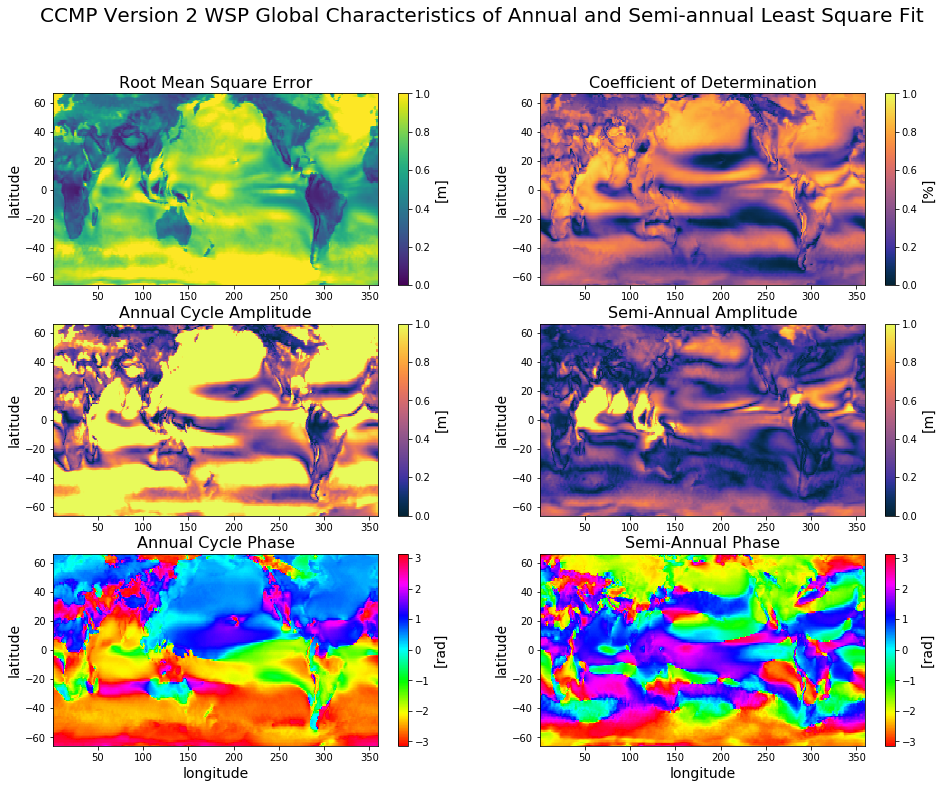

In [14]:
#initialize figure: 
fig2 = plt.figure(figsize=(16, 12))
fig2.suptitle('CCMP Version 2 WSP Global Characteristics of Annual and Semi-annual Least Square Fit ', fontsize=20)

#RMS subplot: 
plt.subplot(321)
plt.pcolor(lon_c,lat_c,wsp_rms_m,vmin=0,vmax=1, cmap=cm.viridis)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Root Mean Square Error', fontsize=16)

#Coefficient of Determination subplot: 
plt.subplot(322)
plt.pcolor(lon_c,lat_c,wsp_cod_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[%]', fontsize=14)
#label figure 
plt.title('Coefficient of Determination', fontsize=16)

#Annual Amplitude subplot: 
plt.subplot(323)
plt.pcolor(lon_c,lat_c,wsp_amp1_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Annual Cycle Amplitude', fontsize=16)

#Semi-annual Amplitude subplot: 
plt.subplot(324)
plt.pcolor(lon_c,lat_c,wsp_amp2_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Semi-Annual Amplitude', fontsize=16)

#Annual Phase subplot: 
plt.subplot(325)
plt.pcolor(lon_c,lat_c,wsp_phase1_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Annual Cycle Phase', fontsize=16)

#Semi-annual Phase subplot: 
plt.subplot(326)
plt.pcolor(lon_c,lat_c,wsp_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Semi-Annual Phase', fontsize=16)


Cartopy projection plots

In [15]:
def set_subplots_c(ax, projection, resolution, lon_min, lon_max, lat_min, lat_max):
    
    """
    set_subplots(ax, projection)
    
        Function for placing x and y axes labels for longitude and latitude respectively
        
        Parameters 
        ----------
        ax : geospatial axes for the subplot (cartopy object)
               e.g. fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
                    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 
        lon_min, lon_max : minimum and maximum extent for longitude on the scale from -180 to 179 
               e.g. lon_min = -180, lon_max = 179
        lat_min, lat_max : minimum and maximum extent for latitude on the scale from -90 to 89
               e.g. lat_min = -66, lat_max = 66
        
              
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
        from matplotlib import ticker
    
    """
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.coastlines(resolution=resolution)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, facecolor = 'Gray'))
    
    return

def set_cbar_c(cs, cax, fig, cbar_label, nbins, fontsize):
    
    """
    set_cbar(cs, cax, fig, cbar_label, nbins, fontsize)
    
        Function for placing x and y axes labels for longitude and latitude respectively
        
        Parameters 
        ----------
        cs : map of data on subplot axis using cartopy projection 
               e.g. cs = ax.pcolor(lon,lat,swh_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv, transform=ccrs.PlateCarree(central_longitude=0.0))
        cax : colorbar axis with positioning vector of the colorbar with the folowing parameters: 
               cax = plt.axes([left, bottom, width, height])
               e.g. cax = plt.axes([.47, .17, 0.01, 0.16])
        fig : fig with the colorbar will attached to (not refering to the subplots)
        cbar_label : colobar label in string format 
               e.g. cbar_label = '[m]'
        fontsize : font size of cbar label
               e.g. fontsize = 10
        nbins : number of tick marks on colorbar axis 
               e.g. nbins = 5
              
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
        from matplotlib import ticker
    
    """
    
    #cax, kw = matplotlib.colorbar.make_axes(ax, location='right', pad=14, shrink=0.6)
    cbar = fig.colorbar(cs, cax=cax, extend='both')
    cbar.ax.set_ylabel('%s' %cbar_label, fontsize=fontsize)
    tick_locator = ticker.MaxNLocator(nbins=nbins)
    cbar.locator = tick_locator 
    cbar.update_ticks()
    
    return

def subplot_label_c(ax, xdist_label, ydist_label, subplot_label, fs_shade, fs_main):
    
    """
    subplot_label(ax, xdist_label, ydist_label, subplot_label, fs_shade, fs_main)
    
        Function for placing subplot labels on subplots for figures that will be used in research papers 
        
        Parameters 
        ----------
        ax : geospatial axes for the subplot (cartopy object)
               e.g. fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
                    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 
        xdist_label : horizontal distance from plot for latitude label
               e.g. xdist_label = 0.2
        ydist_label : vertical distance for latitude label referenced from bottom of figure 
               e.g. ydist_label = 0.8
        subplot_label : string of words for label 
               e.g. subplot_label = 'A'
        fs_shade : font size of shading label
               e.g. fs_shade = 28
        fs_main : font size of main label 
               e.g. fs_main = 18
               
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
    
    
    """
    
    #ax.text(xdist_label, ydist_label, '%s' %subplot_label, va='center', ha='center',
    #    transform=ax.transAxes, fontsize=fs_shade, fontweight='bold', color='gray')
    ax.text(xdist_label, ydist_label, '%s' %subplot_label, va='center', ha='center',
        transform=ax.transAxes, fontsize=fs_main, 
        bbox = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1, alpha=.8), fontweight='bold')
    
    return

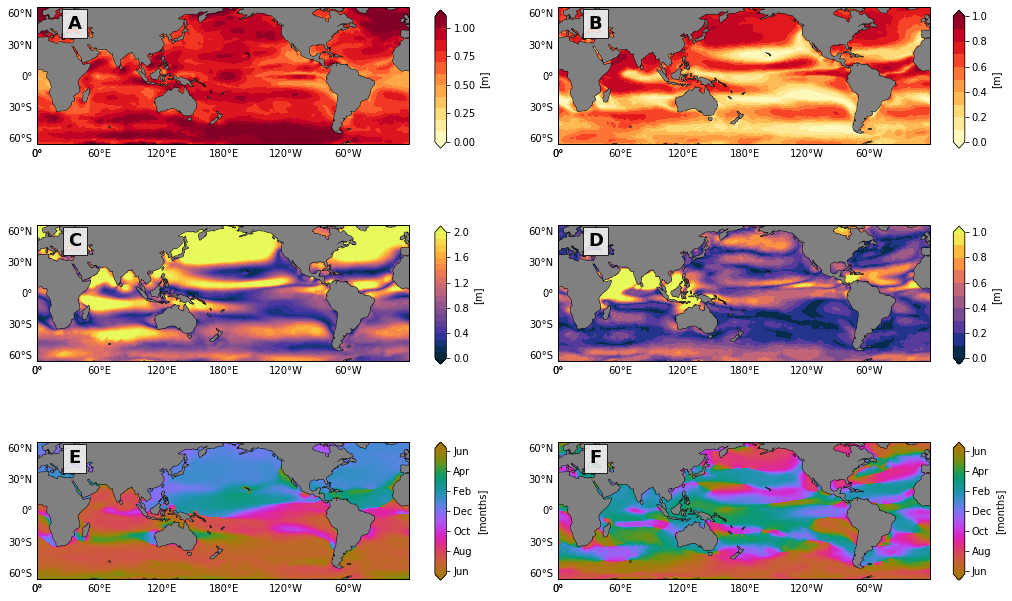

In [20]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '110m'

fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 1.2, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, wsp_rms_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
#left, bottom, width, height
cax1 = plt.axes([.47, .67, 0.01, 0.16])
cart.set_cbar(cs1, cax1, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, wsp_cod_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax2 = plt.axes([.92, .67, 0.01, 0.16])
cart.set_cbar(cs2, cax2, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, wsp_amp1_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax3 = plt.axes([.47, .42, 0.01, 0.16])
cart.set_cbar(cs3, cax3, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, wsp_amp2_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax4 = plt.axes([.92, .42, 0.01, 0.16])
cart.set_cbar(cs4, cax4, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
cs5 = ax5.pcolor(lon_c, lat_c, wsp_phase1_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax5 = plt.axes([.47, .17, 0.01, 0.16])
cart.set_cbar(cs5, cax5, fig, orientation='vertical', cbar_label ='[months]', nbins = 7, fontsize = 10, cbar_ticks=[np.arange(-np.pi, np.pi+0.5, (np.pi + np.pi)/6).tolist(),['','Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr', 'Jun']], task='custom ticks')
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
cs6 = ax6.pcolor(lon_c, lat_c, wsp_phase2_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax6 = plt.axes([.92, .17, 0.01, 0.16])
cart.set_cbar(cs6, cax6, fig, orientation='vertical', cbar_label ='[months]', nbins = 7, fontsize = 10, cbar_ticks=[np.arange(-np.pi, np.pi+0.5, (np.pi + np.pi)/6).tolist(),['','Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr', 'Jun']], task='custom ticks')
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.4, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_wsp_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)

Save ccmp2 wsp annual phase array in a .npz file

In [18]:
np.savez('/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/char_lsf_5par_npz/ccmp2_wsp_char_lsf', wsp_annual_phase = wsp_phase1_m, wsp_annual_amp = wsp_amp1_m, wsp_semi_annual_phase = wsp_phase2_m, wsp_semi_annual_amp = wsp_amp2_m, wsp_cod = wsp_cod_m, wsp_rms = wsp_rms_m)

In [19]:
np.savez('/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/month_averaged_ccmp_v2_data/char_lsf_5par_npz/ccmp2_wsp_month_data_std_hfit', wsp_monthly_mean = wsp_monthly_mean, wsp_monthly_std = wsp_monthly_std, wsp_hfit = wsp_hfit_m)


Plot one time step of CCMP2 gridded wsp data 

In [ ]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(1, 1, figsize=(12,12),
                        subplot_kw={'projection': projection})
ax1 = axes

set_subplots_c(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
#levels = np.arange(0, 4.1, 0.1)
#cs1 = ax1.contourf(lon, lat, swh[0,:,:], levels=levels, cmap=cmo.thermal,
#                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cs1 = ax1.pcolor(lon, lat, swh[0,:,:], vmin=0, vmax=4, cmap=cmo.thermal, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.92, .4, 0.01, 0.2])
set_cbar_c(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/satellite_tracks/satellite_tracks_93', bbox_inches = 'tight', dpi=300)


### Developmental Code

In [ ]:
print(wsp_array.shape)

In [ ]:
test = np.ones((4,4,4))
test[1,1,:] = 2
test[2,2,:] = 3
test[3,3,:] = 4
print(test)

In [ ]:
print(test[0:2,:,:])
print(test[2:4,:,:])

In [ ]:
time_array = np.ma.masked_all([nt])
print(time_array.shape)

In [ ]:
t_con = np.ma.masked_all([nt])
t_c = np.asarray(time_array))
for t in range(0,24,1):
    t_i = t_c[t]
    t_f = 
    

In [ ]:
import datetime
start = datetime.datetime(1993, 1, 1)
dt_array = np.array([start + datetime.timedelta(days=i) for i in range(8400)])
print(dt_array)

In [ ]:
print(filenames)
filenames = filenames[0:23]
print(filenames)

In [ ]:
#find initial and final indices: 
#create time series array:  
start = datetime.datetime(1993, 1, 1)
time_c= np.array([start + datetime.timedelta(days=i) for i in range(8400)])
#create year vector:
years = np.array([y.year for y in time_c])

#create boolean array 
ind_time = years != 2016

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matirx along the time axis from swh
wsp_c = np.compress(ind_time, wsp_array, axis = 0)
print(swh_c.shape,time_c.shape)

In [ ]:
List = [np.array([1, 2, 3, 4, 5]), np.array([1, 2, 3, 4, 5]), np.array([1,2,3,4,5])]
print(List)
new_list = np.concatenate(List, axis = 0)
print(new_list)
new_time = np.hstack( time_array )
#new_time = np.concatenate(time_array, axis = 0)
print(new_time[0].shape)

In [ ]:
print(type(time_c))

In [ ]:
cart.set_subplots?

Deresolve each of the characteristics of the Least square fit such that the resolution of the figure matches that of Ifremer data

In [ ]:
#import running mean library:
from running_mean import running_mean 

#reset nlon and nlat to i degree resolution: 
nlon_c = 360
nlat_c = 133

#initialize 3D array: 
wsp_rms_c = np.ma.masked_all([nlat_c, nlon_c])
wsp_amp1_c = np.ma.masked_all([nlat_c, nlon_c])
wsp_phase1_ = np.ma.masked_all([nlat_c, nlon_c])
wsp_amp2_c = np.ma.masked_all([nlat_c, nlon_c])
wsp_phase2_c = np.ma.masked_all([nlat_c, nlon_c])
wsp_cod_c = np.ma.masked_all([nlat_c, nlon_c])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    wsp_rms_d  = wsp_rms_m[itime,:,:]
    wsp_amp1_d  = wsp_amp1_m[itime,:,:]
    wsp_phase1_d  = wsp_phase1_m[itime,:,:]
    wsp_amp2_d  = wsp_amp2_m[itime,:,:]
    wsp_phase2_d  = wsp_phase2_m[itime,:,:]
    wsp_cod_d  = wsp_cod_m[itime,:,:]
    #preform the deresolution via convolution 
    wsp_rms_dr = running_mean(data = wsp_rms_d, k_dim = [4, 4], task = 'deresolve')
    wsp_amp1_dr = running_mean(data = wsp_amp1_d, k_dim = [4, 4], task = 'deresolve')
    wsp_phase1_dr = running_mean(data = wsp_phase1_d, k_dim = [4, 4], task = 'deresolve')
    wsp_amp2_dr = running_mean(data = wsp_amp2_d, k_dim = [4, 4], task = 'deresolve')
    wsp_phase2_dr = running_mean(data = wsp_phase2_d, k_dim = [4, 4], task = 'deresolve')
    wsp_cod_dr = running_mean(data = wsp_cod_d, k_dim = [4, 4], task = 'deresolve')
    #Save running mean wsp into 3D array: 
    wsp_rms_c[itime,:,:] = wsp_rms_dr
    wsp_amp1_c[itime,:,:] = wsp_amp1_dr
    wsp_phase1_c[itime,:,:] = wsp_phase1_dr
    wsp_amp2_c[itime,:,:] = wsp_amp2_dr
    wsp_phase2_c[itime,:,:] = wsp_phase2_dr
    wsp_cod_c[itime,:,:] = wsp_cod_dr

In [ ]:
lat_c[132] = 66.25
print(lon_c.shape,lat_c)

In [ ]:
dir(ax1.text())

In [ ]:
print(lon_c,lat_c)

In [ ]:
time = np.arange(0,4*np.pi,np.pi/20)
print(time)
#plt.plot(time,2*np.sin(time))
plt.plot(time,2*np.sin(1*time))
plt.plot(time,2*np.sin(1*time + np.pi))
plt.plot(time,2*np.sin(1*time + np.pi/2))
plt.plot(time,2*np.sin(1*time + 3*np.pi/2))
plt.plot(time,2*np.sin(1*time + 2*np.pi))


In [ ]:
print(lat_c)
print(lon_c)
lat_c[132] = 66.25

In [21]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
